In [682]:
import numpy as np
import math
import statsmodels.api as sm
import imblearn
from tqdm.notebook import tqdm
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite, community 
from numpy import nansum
from numpy import nanmean
from numpy.random import choice
import itertools
from networkx.algorithms import community
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)

## Bipartite network generation

### Data preparation

In [683]:
cb1 = pd.read_csv('cb1.csv')
cb2 = pd.read_csv('cb2.csv')
cb3 = pd.read_csv('cb3.csv')

In [684]:
cb = cb1.append(cb2)
cb = cb.append(cb3)
cb.index = range(len(cb))

In [685]:
cb['date_my'] = (pd.to_datetime(cb['date'],format='%m/%d/%Y', errors='coerce')).dt.to_period('m')
cb['date_y'] = (pd.to_datetime(cb['date'],format='%m/%d/%Y', errors='coerce')).dt.to_period('y')

# DESCRIZIONE

In [686]:
cb.groupby(['target_continent','investor_continent']).size().unstack(fill_value=0)

investor_continent,Africa,Asia,Australia,Europe,North America,South America
target_continent,,,,,,
Africa,269,53,3,123,116,0
Asia,34,19159,37,736,2464,6
Australia,0,55,605,62,210,1
Europe,20,745,82,23014,3904,35
North America,47,4081,331,6584,83604,57
South America,0,14,4,99,203,516


In [687]:
cb_a = cb.groupby(['target_continent','investor_continent']).size().unstack(fill_value=0)
cb_a["sum"] = cb_a.sum(axis = 0)
cb_a = cb_a.loc[:,"Africa":"South America"].div(cb_a["sum"], axis=0)
cb_a

investor_continent,Africa,Asia,Australia,Europe,North America,South America
target_continent,,,,,,
Africa,0.727027,0.143243,0.008108,0.332432,0.313514,0.000000
Asia,0.001410,0.794748,0.001535,0.030531,0.102211,0.000249
Australia,0.000000,0.051789,0.569680,0.058380,0.197740,0.000942
Europe,0.000653,0.024332,0.002678,0.751649,0.127507,0.001143
North America,0.000519,0.045093,0.003657,0.072751,0.923791,0.000630
South America,0.000000,0.022764,0.006504,0.160976,0.330081,0.839024


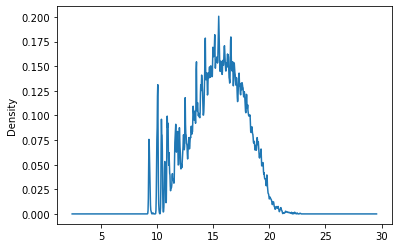

In [688]:
es1 = cb.groupby(['target_name','stage'], as_index = False).agg({"size_real": 'first'})
es2 = es1[['target_name','size_real']].groupby(['target_name'],as_index=False).sum()
es3 = es2[es2['size_real']!=0]
np.log(es3['size_real']).plot.kde(0.01)

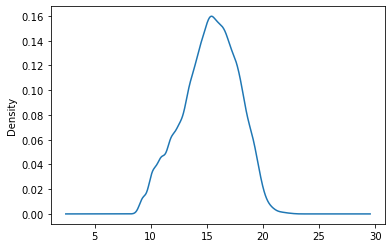

In [689]:
np.log(es3['size_real']).plot.kde()

In [690]:
es3.sort_values("size_real",ascending=False)[0:300]

,target_name,size_real
13696,DuPont Nutrition & Biosciences,7.746618e+09
17516,Genentech,7.290045e+09
23740,Kindred at Home,5.853121e+09
40403,Siemens Healthineers,5.710232e+09
38407,Roche Holding,5.000450e+09
5675,BeiGene,4.797594e+09
18689,HCA Healthcare,4.650897e+09
1110,Acerta Pharma,4.625006e+09
8372,Canopy Growth,4.520272e+09
5514,Bayer,4.050744e+09


In [691]:
cb[cb['target_name']=='zumutor']

,target_name,stage,size_MLN,date,investors_name,url,description,industry,target_country,target_collections,target_status,target_ID,target_founded,round_simp,target_continent,target_state,target_city,target_street,target_people,target_competitors,investor_name,investor_url,investor_description,investor_country,investor_type,investor_deals_now,investor_companies,investor_deals_total,investor_exit_12,investor_ppl,investor_deals_12,investor_collections,investor_id,investor_industry,investor_state,investor_continent,investor_city,investor_founded,investor_street,date_dt,DATE,CPIAUCSL,size_real,date_my,date_y
4161,zumutor,Other Investors,NaN,NaN,Chiratae Ventures,zumutor.com,Zumutor is an immuno-oncology company that dev...,Biotechnology,United States,"Regenerative Medicine, Biopharmaceuticals and ...",Alive / Active,348607,2013.0,Other Investors,North America,Massachusetts,Cambridge,CIC Cambridge Campus 1 Broadway…,"Kavitha Rodrigues (CEO),Anirban Bhattacharya (...",NaN,Chiratae Ventures,chiratae.com,"Chiratae Ventures, formerly IDG Ventures India...",India,Venture Capital,44.0,19.0,256,3.0,"T. Meenakshisundaram (CFO),Manik Arora (Managi...",51.0,"Pharma Startups, Fitness Tech and Untitled…",1572.0,NaN,NaN,Asia,Bengaluru,2006.0,"7B, 7th Floor, Sobha Pearl 1, Commissariat Road…",NaN,NaN,NaN,NaN,NaT,NaT
151846,zumutor,Series A,4.0,11/27/2019,Accel,zumutor.com,Zumutor is an immuno-oncology company that dev...,Biotechnology,United States,"Regenerative Medicine, Biopharmaceuticals and ...",Alive / Active,348607,2013.0,Series A,North America,Massachusetts,Cambridge,CIC Cambridge Campus 1 Broadway…,"Kavitha Rodrigues (CEO),Anirban Bhattacharya (...",NaN,Accel,accel.com,Accel is a venture capital firm that invests i...,United States,Venture Capital,115.0,58.0,"2,061",33.0,NaN,176.0,"Identity Management, Direct-To-Consumer Brands...",203.0,Investment Firms & Funds,California,North America,Palo Alto,1983.0,500 University Avenue,2019-11,2019-11,257.989,4.248243e+06,2019-11,2019
151847,zumutor,Series A,4.0,11/27/2019,Bharat Fund,zumutor.com,Zumutor is an immuno-oncology company that dev...,Biotechnology,United States,"Regenerative Medicine, Biopharmaceuticals and ...",Alive / Active,348607,2013.0,Series A,North America,Massachusetts,Cambridge,CIC Cambridge Campus 1 Broadway…,"Kavitha Rodrigues (CEO),Anirban Bhattacharya (...",NaN,Bharat Fund,bharat.fund,Bharat Fund is an early stage venture fund wit...,India,Venture Capital,1.0,1.0,10,0.0,NaN,4.0,NaN,100506.0,NaN,NaN,Asia,Ahmedabad,NaN,Centre for Innovation Incubation and Entrepren...,2019-11,2019-11,257.989,4.248243e+06,2019-11,2019


In [129]:
cb

,target_name,stage,size_MLN,date,investors_name,url,description,industry,target_country,target_collections,target_status,target_ID,target_founded,round_simp,target_continent,target_state,target_city,target_street,target_people,target_competitors,investor_name,investor_url,investor_description,investor_country,investor_type,investor_deals_now,investor_companies,investor_deals_total,investor_exit_12,investor_ppl,investor_deals_12,investor_collections,investor_id,investor_industry,investor_state,investor_continent,investor_city,investor_founded,investor_street,date_dt,DATE,CPIAUCSL,size_real,date_my,date_y
0,Shionogi & Co.,IPO,NaN,05/16/1949,Public,shionogi.com,Shionogi & Co. (TYO: 4507) focuses on the rese...,Pharmaceuticals / Drugs,Japan,Pharma Startups,IPO / Went public,262824,1878.0,IPO,Asia,NaN,Osaka,"1-8, Doshomachi 3-chome Chuo-ku…",NaN,Sumitomo Dainippon Pharma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949
1,Astellas Pharma,IPO,NaN,05/16/1949,Public,astellas.com,Astellas Pharma (TSE: 4503) specializes in the...,Pharmaceuticals / Drugs,Japan,"Digital Therapeutics, Pharma Startups, Cancer ...",IPO / Went public,243168,1923.0,IPO,Asia,NaN,Tokyo,"2-5-1, Nihonbashi-Honcho, Chuo-ku…","Yoshihiko Hatanaka (CEO),Yoshirou Myyokawa (EV...",Sumitomo Dainippon Pharma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949
2,Sumitomo Dainippon Pharma,IPO,NaN,05/16/1949,Public,ds-pharma.com,Sumitomo Dainippon Pharma (TYO: 4506) is a pha...,Pharmaceuticals / Drugs,Japan,Digital Therapeutics and Pharma Startups…,IPO / Went public,447180,1897.0,IPO,Asia,NaN,Osaka,"6-8, Doshomachi 2-chome Chuo-ku…",Masayo Tada (CEO),"Astellas Pharma,Chugai Pharmaceutical,Daiichi ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949
3,Konica Minolta,IPO,NaN,05/16/1949,Public,konicaminolta.com,"Konica Minolta (コニカミノルタ) (TYO: 4902), founded ...",Medical Devices & Equipment,Japan,Conference Exhibitors,IPO / Went public,57191,1936.0,IPO,Asia,NaN,Tokyo,"JP Tower 2-7-2 Marunouchi, Chiyoda-ku…",Michael Mathé (SVP),Xerox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949
4,Takeda Pharmaceutical,IPO,NaN,05/16/1949,Public,takeda.com,Takeda Pharmaceutical (TYO: 4502) (NYSE: TAK) ...,Pharmaceuticals / Drugs,Japan,"Poop Tech, Pharma Startups, Rare Diseases, Sle...",IPO / Went public,373007,1781.0,IPO,Asia,NaN,Tokyo,"2-1-1 Nihonbashihonmachi, Chuo-ku…","Frank Morich (CEO),Yasuchika Hasegawa (CEO),Da...","Sumitomo Dainippon Pharma,Sunovion…",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187799,Beijing Shouyi,Acquired,NaN,08/17/2021,Healgen,shouyi-biochem.com…,"Beijing Shouyi is a biomedical enterprise, whi...",Medical Devices & Equipment,China,NaN,Acquired,669346,1998.0,Acquisition,Asia,Beijing,Beijing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08,2021-08,274.00,NaN,2021-08,2021
187800,Centaur Labs,Series A,15.89,08/17/2021,Undisclosed Investors,centaurlabs.com,Centaur Labs enables customers to build AI alg...,Internet Software & Services,United States,"Digital Health, Artificial Intelligence ( AI )...",Alive / Active,377820,2017.0,Series A,North America,Massachusetts,Boston,"883 Boylston St, Suite 200…","Erik Duhaime (CEO),Zach Rausnitz (CTO)…",Aigorithm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08,2021-08,274.00,15890000.0,2021-08,2021
187801,Streamline Health Solutions,IPO,NaN,08/17/2021,Public,streamlinehealth.net,Streamline Health (NASDAQ: STRM) provides solu...,Healthcare Softwa

In [692]:
cb[cb['investors_name']=='Public'][-300:]

,target_name,stage,size_MLN,date,investors_name,url,description,industry,target_country,target_collections,target_status,target_ID,target_founded,round_simp,target_continent,target_state,target_city,target_street,target_people,target_competitors,investor_name,investor_url,investor_description,investor_country,investor_type,investor_deals_now,investor_companies,investor_deals_total,investor_exit_12,investor_ppl,investor_deals_12,investor_collections,investor_id,investor_industry,investor_state,investor_continent,investor_city,investor_founded,investor_street,date_dt,DATE,CPIAUCSL,size_real,date_my,date_y
168627,Vaccibody,IPO,NaN,10/07/2020,Public,vaccibody.com,Vaccibody is a vaccine company dedicated to th...,Drug Development,Norway,"Pharma Startups, Cancer Therapeutics, Biopharm...",IPO / Went public,83448,2007.0,IPO,Europe,NaN,Oslo,Oslo Research Park Gaustadalleen 21…,Martin Bonde (CEO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10,2020-10,260.462,NaN,2020-10,2020
168697,Aziyo Biologics,IPO,133.06,10/08/2020,Public,aziyo.com,Aziyo Biologics (NASDAQ: AZYO) is a biotech co...,Biotechnology,United States,"Pharma Startups, Regenerative Medicine and Bio...",IPO / Went public,287569,2015.0,IPO,North America,Maryland,Silver Spring,12510 Prosperity Drive Suite 370…,Ronald Lloyd (CEO),Pinnacle Transplant Technologies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10,2020-10,260.462,1.399760e+08,2020-10,2020
168742,Shattuck Labs,IPO,150.00,10/09/2020,Public,shattucklabs.com,Shattuck Labs (NASDAQ: STTK) is a biotechnolog...,Drug Development,United States,"Pharma Startups, Cancer Therapeutics, Regenera...",IPO / Went public,260319,2016.0,IPO,North America,Texas,Austin,1018 West 11th Street Suite 100…,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10,2020-10,260.462,1.577965e+08,2020-10,2020
168743,Spruce Biosciences,IPO,75.00,10/09/2020,Public,sprucebiosciences.com,Spruce Biosciences (NASDAQ: SPRB) is a clinica...,Biotechnology,United States,Rare Diseases and Biopharmaceuticals…,IPO / Went public,302492,2014.0,IPO,North America,California,San Francisco,2001 Junipero Serra Blvd. Suite 640…,"Alexis Howerton Ph.D. (Founder),Richard King (...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10,2020-10,260.462,7.889827e+07,2020-10,2020
168761,Everest Medicines,IPO,451.00,10/09/2020,Public,everestmedicines.com,Everest Medicines (01952.HK) is dedicated to d...,Drug Development,United States,Pharma Startups and Biopharmaceuticals…,IPO / Went public,331239,2017.0,IPO,North America,New York,New York,450 Lexington Ave Suite 39B…,Sean Cao (CEO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10,2020-10,260.462,4.744416e+08,2020-10,2020
168762,Kronos Bio,IPO,250.00,10/09/2020,Public,kronosbio.com,Kronos Bio is dedicated to the research and de...,Biotechnology,United States,"Pharma Startups, Biopharmaceuticals and Cancer…",IPO / Went public,326897,2017.0,IPO,North America,California,San Mateo,1300 So. El Camino Real Suite 300…,"Angela Koehler (Founder),Norbert Bischofberger...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10,2020-10,260.462,2.629942e+08,2020-10,2020
168764,CSAM Health,IPO,NaN,10/09/2020,Public,csamhealth.com,CSAM is a privately-owned eHealth company base...,Healthcare Software,Norway,Digital Health and Cancer,IPO / Went public,184102,NaN,IPO,Europe,NaN,Oslo,Lysaker Torg 45b,"Sverre Flatby (CEO),Anne Quirk (CEO),Marcelino...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10,2020-10,260.462,NaN,2020-10,2020
168991,Codiak Biosciences,IPO,82.50,10/14/2020,Public,codiakbio.com,Codiak Biosciences is developing multiple plat...,Biotechnology,United States,"Pharma Startups, Regenerative Medicine and Bio...",IPO / Went public,243151,2015.0,IPO,North America,Massachusetts,Cambri

In [693]:
#ordinare gli investitori

inv_list = list(cb['investors_name'].values)
inv_counter = {}
for inv in inv_list:
    if inv in inv_counter:
        inv_counter[inv] += 1
    else:
        inv_counter[inv] = 1

popular_invs = sorted(inv_counter, key = inv_counter.get, reverse = True)
 
top = popular_invs[:20]

In [694]:
for i in popular_invs:
    if pd.isna(i):
        print(i)

nan


In [695]:
inv_counter['Dead']

353

# GRAPHS

In [696]:
nodes_org = cb[['target_name', 'target_ID']].drop_duplicates()
nodes_org['bipartite'] = 1
nodes_inv = cb[['investors_name', 'investor_id']].drop_duplicates()
nodes_org = nodes_org.rename(columns={"target_name": "node", "target_country": "country", 
                                      "target_continent": "continent", "industry":"industry",
                                     "target_ID":"index"})
nodes_inv = nodes_inv.rename(columns={"investors_name": "node","investor_country": "country", 
                                      "investor_continent": "continent", "investor_type":"industry","investor_id":'index' })
nodes_inv['bipartite'] = 0
nodes = nodes_org.append(nodes_inv, ignore_index= True)
nodes['id'] = nodes.index
nodes

,node,index,bipartite,id
0,Shionogi & Co.,262824.0,1,0
1,Astellas Pharma,243168.0,1,1
2,Sumitomo Dainippon Pharma,447180.0,1,2
3,Konica Minolta,57191.0,1,3
4,Takeda Pharmaceutical,373007.0,1,4
...,...,...,...,...
83253,Shenzhen Qianhai Beizeng Asset Management Co. ...,179782.0,0,83253
83254,Wuxi High-Tech District Seed Fund,189318.0,0,83254
83255,Edvantage Group,190377.0,0,83255
83256,Healgen,NaN,0,83256


In [697]:
numbers = cb.groupby(['target_name','stage'], as_index = False).count()[['target_name','stage','investors_name']].rename(columns={"investors_name": "investor_numbers"})

In [698]:
cb_new = pd.merge(cb, numbers,  how='left', left_on=['target_name','stage'], right_on = ['target_name','stage'])
cb_new = pd.merge(cb_new, nodes[nodes['bipartite']== 1],  how='left', left_on=['target_name','target_ID'], right_on = ['node','index'])
cb_new = pd.merge(cb_new, nodes[nodes['bipartite']== 0],  how='left', left_on=['investors_name','investor_id'], right_on = ['node','index'])


In [699]:
##ripeto quanto fatto prima (semplificato prima per risparmiare tempo) ma aggiungo roba
nodes_org = cb_new[['target_name', 'target_ID', 'target_country', 'target_continent',
               'industry','target_founded','target_status']].drop_duplicates()
nodes_org['bipartite'] = 1
nodes_inv = cb_new[['investors_name', 'investor_id', 'investor_country', 'investor_continent', 'investor_type',
                   'investor_founded']].drop_duplicates()
nodes_org = nodes_org.rename(columns={"target_name": "node", "target_country": "country", 
                                      "target_continent": "continent", "industry":"industry",
                                     "target_ID":"index", "target_founded":"foundation"})
nodes_inv = nodes_inv.rename(columns={"investors_name": "node","investor_country": "country", 
                                      "investor_continent": "continent", "investor_type":"industry", "investor_id":'index',
                                     "investor_founded":"foundation"})
nodes_inv['bipartite'] = 0
nodes = nodes_org.append(nodes_inv, ignore_index= True)
nodes['id'] = nodes.index
nodes.columns



Index(['node', 'index', 'country', 'continent', 'industry', 'foundation',
       'target_status', 'bipartite', 'id'],
      dtype='object')

In [700]:
B = nx.MultiGraph(name='org-bid')
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(nodes[nodes.bipartite==0].id)
B.add_nodes_from(nodes[nodes.bipartite==1].id)
nx.set_node_attributes(B, pd.Series(nodes.node, index=nodes.id).to_dict(), 'name')
nx.set_node_attributes(B, pd.Series(nodes.country, index=nodes.id).to_dict(), 'country')
nx.set_node_attributes(B, pd.Series(nodes.continent, index=nodes.continent).to_dict(), 'continent')
nx.set_node_attributes(B, pd.Series(nodes.industry, index=nodes.id).to_dict(), 'industry')
nx.set_node_attributes(B, pd.Series(nodes.foundation, index=nodes.id).to_dict(), 'foundation')
nx.set_node_attributes(B, pd.Series(nodes.bipartite, index=nodes.id).to_dict(), 'bipartite')
nx.set_node_attributes(B, pd.Series(nodes.target_status, index=nodes.id).to_dict(), 'target_status')
# Add edges only between nodes of opposite node sets
for i in range(len(cb_new)):
    B.add_edge(cb_new.loc[i,'id_y'], cb_new.loc[i,'id_x'], date=(cb_new.loc[i,'date_y']).year, m_raised=cb_new.loc[i,'size_real'], 
               investors = cb_new.loc[i,'investor_numbers'], round_simp =cb_new.loc[i,'round_simp'])

In [296]:
##nodi brutti
#'Undisclosed Investors',
# 'Public',
#'Undisclosed Angel Investors',
#'Undisclosed Venture Investors',
#Dead


KeyError: 'na'

In [701]:
brutti = [x for x,y in B.nodes(data=True) if (y['name']=='Undisclosed Investors') or (y['name']=='Dead')   or (y['name']=='Public')  
          or  (y['name']=='Undisclosed Angel Investors') or (y['name']=='Undisclosed Venture Investors')]
B.remove_nodes_from(brutti)

In [ ]:
'Grant - XIII'

In [410]:
biz = [(x,y) for x,y,d in B.edges(data=True) if (d['round_simp']=='Portfolio Merger')]
biz

[(53555, 18400),
 (53882, 13658),
 (54420, 11461),
 (54420, 12507),
 (58370, 7975),
 (59311, 19853),
 (59311, 19910),
 (60228, 13572),
 (62332, 19486),
 (62332, 18609)]

In [702]:
##degree sorting
sorted(B.degree, key=lambda x: x[1], reverse=True)

[(77356, 1675),
 (50667, 714),
 (51253, 652),
 (50770, 522),
 (51291, 511),
 (61693, 503),
 (51084, 497),
 (51153, 423),
 (50481, 421),
 (52034, 412),
 (50595, 406),
 (51077, 384),
 (50939, 382),
 (50917, 353),
 (52117, 341),
 (50766, 339),
 (55496, 334),
 (50685, 332),
 (51859, 331),
 (50919, 321),
 (50605, 316),
 (51276, 314),
 (52119, 309),
 (50859, 306),
 (50768, 301),
 (51512, 290),
 (51204, 275),
 (50516, 270),
 (50519, 266),
 (50683, 265),
 (51263, 257),
 (54061, 250),
 (51494, 245),
 (56764, 245),
 (53091, 242),
 (50577, 241),
 (50480, 240),
 (51305, 240),
 (61514, 238),
 (50515, 236),
 (50710, 232),
 (57908, 229),
 (50594, 223),
 (50585, 208),
 (50668, 207),
 (51175, 199),
 (50599, 197),
 (50985, 195),
 (52353, 194),
 (55245, 194),
 (50703, 193),
 (50751, 193),
 (52127, 192),
 (52142, 186),
 (53252, 181),
 (58978, 180),
 (51005, 178),
 (50512, 177),
 (51709, 174),
 (51021, 173),
 (51293, 169),
 (63591, 168),
 (51063, 166),
 (51310, 165),
 (55129, 165),
 (50727, 162),
 (54057, 

In [374]:
B.nodes[1119]

{'name': 'Bioenvision',
 'country': 'United States',
 'industry': 'Biotechnology',
 'foundation': 1996.0,
 'bipartite': 1,
 'target_status': 'Acquired'}

In [703]:
bid_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
org_nodes = set(B) - bid_nodes

# NEW GRAPHS

# FOLLOWERS

In [ ]:
#DA SISTEMARE

G_bidder_follow=nx.MultiDiGraph()
for org in Pallottola.Organisation.unique():
    ord_list = list(Pallottola[Pallottola.Organisation==org].sort_values(by=['Date']).id_y)
    time_list= list(Pallottola[Pallottola.Organisation==org].sort_values(by=['Date']).Date.dt.year)
    for idx in range(len(ord_list)):
        if ord_list[idx]!= np.nan:
            for seq in range(idx, len(ord_list)):
                if ord_list[seq]!=np.nan:
                    G_bidder_follow.add_edge(ord_list[idx], ord_list[seq], year=time_list[seq])

# BIDBID

In [704]:
id_round = cb_new[['target_ID','round_simp']]
id_round = id_round.drop_duplicates()
id_round.index = range(len(id_round))
id_round['id_round'] = id_round.index
id_round

id_year = cb_new[['target_ID','date_y']]
id_year = id_year.drop_duplicates()
id_year.index = range(len(id_year))
id_year['id_year'] = id_year.index
id_year

,target_ID,date_y,id_year
0,262824,1949,0
1,243168,1949,1
2,447180,1949,2
3,57191,1949,3
4,373007,1949,4
...,...,...,...
94835,669346,2021,94835
94836,377820,2021,94836
94837,439295,2021,94837
94838,439775,2021,94838


In [705]:
cb_new = pd.merge(cb_new, id_round,  how='left', left_on=['target_ID','round_simp'], right_on = ['target_ID','round_simp'])


In [706]:
cb_new = pd.merge(cb_new, id_year,  how='left', left_on=['target_ID','date_y'], right_on = ['target_ID','date_y'])

In [717]:
##bidbid in stesso anno
links = []
subcb = cb_new[['id_year','date_y','id_y']].drop_duplicates()
subcb = subcb[pd.notna(subcb['date_y'])]
for i in tqdm(subcb['id_year'].unique()):
    subcb2 = subcb[subcb['id_year']==i]
    for couple in itertools.combinations(np.unique(subcb2['id_y'].values),2):
        links.append((couple + ({'date': subcb2['date_y'].values[0].year},)))
bidbid=nx.MultiGraph()
bidbid.add_nodes_from(nodes[nodes.bipartite==0].id)
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.node, index=nodes.id).to_dict(), 'name')
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.country, index=nodes.id).to_dict(), 'country')
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.continent, index=nodes.continent).to_dict(), 'continent')
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.industry, index=nodes.id).to_dict(), 'industry')
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.foundation, index=nodes.id).to_dict(), 'foundation')
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.bipartite, index=nodes.id).to_dict(), 'bipartite')
bidbid.add_edges_from(links) 
remove = [node for node,degree in dict(bidbid.degree()).items() if degree == 0]
bidbid.remove_nodes_from(remove)

In [718]:
bidbid.remove_nodes_from(brutti)

In [719]:
nx.info(bidbid)

'Name: \nType: MultiGraph\nNumber of nodes: 21902\nNumber of edges: 250433\nAverage degree:  22.8685'

In [724]:
nx.readwrite_write_gpickle('bidbid_cb.gpickle')

AttributeError: module 'networkx' has no attribute 'readwrite_write_gpickle'

In [715]:
links

[(50463, 50465, {'date': 1968}),
 (50463, 50465, {'date': 1968}),
 (50668, 50700, {'date': 1979}),
 (50668, 51771, {'date': 1979}),
 (50668, 54085, {'date': 1979}),
 (50700, 51771, {'date': 1979}),
 (50700, 54085, {'date': 1979}),
 (51771, 54085, {'date': 1979}),
 (50668, 50700, {'date': 1979}),
 (50668, 51771, {'date': 1979}),
 (50668, 54085, {'date': 1979}),
 (50700, 51771, {'date': 1979}),
 (50700, 54085, {'date': 1979}),
 (51771, 54085, {'date': 1979}),
 (50668, 50700, {'date': 1979}),
 (50668, 51771, {'date': 1979}),
 (50668, 54085, {'date': 1979}),
 (50700, 51771, {'date': 1979}),
 (50700, 54085, {'date': 1979}),
 (51771, 54085, {'date': 1979}),
 (50668, 50700, {'date': 1979}),
 (50668, 51771, {'date': 1979}),
 (50668, 54085, {'date': 1979}),
 (50700, 51771, {'date': 1979}),
 (50700, 54085, {'date': 1979}),
 (51771, 54085, {'date': 1979}),
 (54087, 54088, {'date': 1981}),
 (54087, 54088, {'date': 1981}),
 (50790, 54090, {'date': 1981}),
 (50790, 54091, {'date': 1981}),
 (54090, 5

In [ ]:
ebunch = [(x,y) for x,y,z in bidbid.edges(data=True) if pd.isna(z['date'])]

while len([(x,y) for x,y,z in bidbid.edges(data=True) if pd.isna(z['date'])])>0:
    ebunch =[(x,y) for x,y,z in bidbid.edges(data=True) if pd.isna(z['date'])]
    for i in range(len(ebunch)):
        bidbid.remove_edges_from([ebunch[i]])

In [678]:
ebunch

True

In [675]:
for q,w,r in bidbid.edges(data = True):
    print(r)

993

In [ ]:
##bidbid in stesso round
links = []
for i in cb_new['id_round'].unique():
    for couple in itertools.combinations(np.unique(cb_new[cb_new['id_round']==i]['id_y'].values),2):
            links_f.append((couple + ({'m_raised': np.unique(Pallottola[Pallottola['idx']==i]['USDraised_cpi'])),
                             'date': min(pd.to_datetime(Pallottola[Pallottola['idx']==i]['Date'].values)),
                             'round': Pallottola[Pallottola['idx']==i]['Funding type'].values[0],
                             'investors': cb_new.unique())),
                 'type': 'invinv'},)))
bidbid=MultiGraph()
bidbid.add_nodes_from(nodes.id)
bidbid.add_edges_from(links_)
    

In [ ]:
cb_new.head()

In [537]:
orgorg=project_multi(B, bid_nodes, name='bid-bid')

10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 2010 2020 2030 2040 2050 2060 2070 2080 2090 2100 2110 2120 2130 2140 2150 2160 2170 2180 2190 2200 2210 222

KeyboardInterrupt: 

# BIDBID

In [559]:
bidbid=project_multi(B, org_nodes, name='org-org')

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 

In [560]:
nx.info(bidbid)

'Name: org-org\nType: MultiGraph\nNumber of nodes: 18179\nNumber of edges: 98776\nAverage degree:  10.8670'

# WINDOW

In [ ]:
from itertools import islice

def window(seq, n):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [ ]:
finestra = window(list(range(2000,2022)),5)

In [ ]:
for periodo in finestra:
    locals()["B_"+str(periodo[-1])]=nx.MultiGraph([(u,v,d) for u,v,d in B.edges(data=True) if d['date'] in periodo])

# COMMUNITIES

In [561]:
partition = community_louvain.best_partition(bidbid)

In [414]:
partition

{50463: 0,
 50465: 1,
 50466: 2,
 50467: 2,
 50468: 3,
 50469: 4,
 50470: 0,
 50471: 1,
 50472: 5,
 50473: 1,
 50474: 1,
 50475: 1,
 50476: 6,
 50477: 7,
 50478: 6,
 50479: 1,
 50480: 2,
 50481: 1,
 50482: 1,
 50483: 2,
 50484: 1,
 50485: 1,
 50486: 8,
 50487: 97,
 50488: 1,
 50489: 1,
 50490: 1,
 50491: 10,
 50492: 1,
 50493: 1,
 50494: 1,
 50495: 11,
 50496: 1,
 50497: 1,
 50498: 3,
 50499: 2,
 50500: 4,
 50501: 1,
 50502: 12,
 50503: 13,
 50504: 14,
 50505: 1,
 50506: 1,
 50507: 1,
 50508: 1,
 50509: 13,
 50510: 13,
 50511: 1,
 50512: 4,
 50513: 15,
 50514: 13,
 50515: 1,
 50516: 1,
 50517: 2,
 50518: 2,
 50519: 2,
 50520: 1,
 50521: 1,
 50522: 14,
 50523: 2,
 50524: 1,
 50525: 13,
 50526: 0,
 50527: 11,
 50528: 3,
 50529: 17,
 50530: 2,
 50531: 1,
 50532: 2,
 50533: 11,
 50534: 14,
 50535: 13,
 50536: 13,
 50537: 2,
 50538: 278,
 50539: 13,
 50540: 1,
 50541: 19,
 50542: 20,
 50543: 1,
 50544: 1,
 50545: 79,
 50546: 13,
 50547: 2,
 50548: 12,
 50549: 22,
 50550: 3,
 50551: 3,
 5055

In [416]:
pos = nx.spring_layout(B)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

MemoryError: Unable to allocate 51.6 GiB for an array with shape (83253, 83253) and data type float64

In [417]:
len(partition)

83253

In [375]:
cb_new.groupby('round_simp').count()

,target_name,stage,size_MLN,date,investors_name,url,description,industry,target_country,target_collections,target_status,target_ID,target_founded,target_continent,target_state,target_city,target_street,target_people,target_competitors,investor_name,investor_url,investor_description,investor_country,investor_type,investor_deals_now,investor_companies,investor_deals_total,investor_exit_12,investor_ppl,investor_deals_12,investor_collections,investor_id,investor_industry,investor_state,investor_continent,investor_city,investor_founded,investor_street,date_dt,DATE,CPIAUCSL,size_real,date_my,date_y,investor_numbers,node_x,index_x,bipartite_x,id_x,node_y,index_y,bipartite_y,id_y
round_simp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Acq - P2P,461,461,2,461,461,406,461,458,459,337,461,461,292,459,392,446,431,266,201,461,448,459,455,453,461,461,461,461,295,461,404,461,401,323,455,449,380,445,461,461,461,2,461,461,461,461,461,461,461,461,461,461,461
Acquisition,12205,12205,90,12154,12205,10393,12205,12060,12184,4235,12205,12205,4834,12184,9260,11373,10781,3797,1285,11566,11022,11347,11292,11092,11566,11566,11566,11566,6559,11566,6297,11566,8323,8825,11292,10977,7300,10771,12154,12154,12154,90,12154,12154,12205,12205,12205,12205,12205,12205,11566,12205,12205
Acquisition (Financial),2518,2518,84,2499,2518,2375,2518,2493,2514,846,2518,2518,1350,2514,1635,2378,2355,1673,267,2422,2362,2398,2392,2405,2422,2422,2422,2422,1895,2422,1086,2422,1001,1776,2392,2322,1257,2338,2499,2499,2499,84,2499,2499,2518,2518,2518,2518,2518,2518,2422,2518,2518
Acquisition (Talent),7,7,0,7,7,5,7,7,7,3,7,7,2,7,6,6,5,2,1,7,7,7,7,7,7,7,7,7,6,7,3,7,7,6,7,7,7,7,7,7,7,0,7,7,7,7,7,7,7,7,7,7,7
Angel,3554,3554,2598,3452,3554,3382,3553,3523,3554,2631,3554,3554,1996,3554,2146,3374,3160,2569,694,2454,1455,1703,1752,2408,2454,2454,2454,2454,937,2454,998,2454,283,1198,1752,1363,252,946,3452,3452,3452,2560,3452,3452,3554,3554,3554,3554,3554,3554,2454,3554,3554
Asset Sale,180,180,5,177,180,162,180,177,180,81,180,180,96,180,131,172,168,101,39,149,129,144,137,135,149,149,149,149,76,149,78,149,96,106,137,130,71,128,177,177,177,5,177,177,180,180,180,180,180,180,149,180,180
Bridge,244,244,209,243,244,234,244,244,244,229,244,244,186,244,166,234,234,179,87,213,184,191,188,206,213,213,213,213,120,213,132,213,49,132,188,164,55,150,243,243,243,208,243,243,244,244,244,244,244,244,213,244,244
Business Plan Competition,968,968,673,965,968,841,968,951,968,887,968,968,601,968,463,855,713,652,114,959,880,945,860,942,959,959,959,959,120,959,253,959,168,461,860,712,177,570,965,965,965,672,965,965,968,968,968,968,968,968,959,968,968
Convertible Note,2664,2664,2296,2662,2664,2465,2664,2643,2664,1915,2664,2664,1885,2664,2056,2605,2566,2073,421,1562,1458,1486,1492,1514,1562,1562,1562,1562,1164,1562,1040,1562,333,1150,1492,1368,573,1331,2662,2662,2662,2294,2662,2662,2664,2664,2664,2664,2664,2664,1562,2664,2664


In [ ]:
'Asset Sale' 'Convertible Note' 'Dead' 'Debt' 'Distressed & Special Situation' 'Leveraged Buyout' 'Line of Credit' 'Loan'
'Mezzanine' 'Merger' 'Revenue Finance' 'Project Finance'